# ConvAutoencoder DataDenoising MNISTdataset

Now we use the Autoencoder for another application: data denoising. In particular, we talk about image denoising.

### Data denoising

Data denoising consists in being able to remove noise from our images. 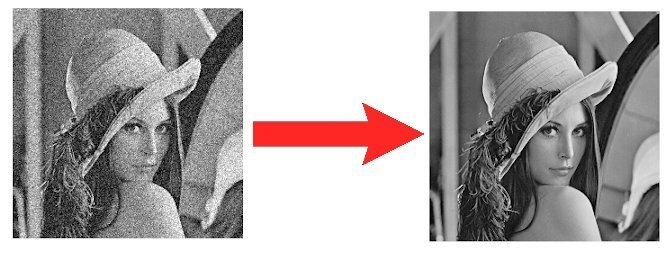

## USING AN AUTOENCODER FOR IMAGE DENOISING

In general, using Autoencoders, we can try to perform some kind of transformation $f$ of our data $x$. Like, in our specific case, we want to perform as function $f$ the denoising transformation.

For being able to perfom the transformation $f$ using an AUtoencoder, we must be know the inverse transformation $f^{-1}$. We must be able to perform the inverse transformation $f^{-1}$. In our specific case, the inverse transformation is about injecting noise into our image. We must know how to inject noise.

The approach for training an Autoencoder for denoising is the following.

### Context

In our context, we have a dataset $x_{train}$ of normal images, without noise.

### Injecting noise into the images

We inject noise into our images, by applying the transformation $f^{-1}$. We obtain the new dataset $x_{train\_noise}$.

### Training the Autoencoder

We train the Autoencoder by using as data the noisy dataset $x_{train\_noise}$ and as labels the normal dataset $x_{train}$. 

Basically, the Autoencoder takes a noisy image $\tilde{x}$, it compresses it into a latent encoding $z$, and then it reconstructs back the normal image $x$, without noise.

We are asking to the Autoencoder to learn how to denoise an image out of an internal latent representation. We are asking to the Autoencoder to learn how to denoise our images. To learn the transformation $f$.

## DENOISING ON THE MNIST DATASET

Image denoising on the MNIST dataset, by means of a Conv Autoencoder.
https://keras.io/examples/vision/autoencoder/

In [1]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose

from tensorflow.keras.models import Model  

from tensorflow.keras.datasets import mnist  # MNIST dataset

import numpy as np

### Dataset

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
print('There are {} samples in the training set'.format(x_train.shape[0]))
print('There are {} samples in the test set'.format(x_test.shape[0]))

There are 60000 samples in the training set
There are 10000 samples in the test set


Normalization

In [4]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

Adding the channels dimension.

In [5]:
(n_train, w, h) = x_train.shape
# Reshaping `x_train`, adding the channels dimension (equal to 1)
x_train = x_train.reshape(n_train, w, h, 1)

(n_test, w, h) = x_test.shape
# Reshaping `n_test`, adding the channels dimension (equal to 1)
x_test = x_test.reshape(n_test, w, h, 1)

### Function for injecting noise

As said before, we must be able to perform the inverse transformation $f^{-1}$ in order to be able to learn $f$.

In [8]:
def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)

### Injecting noise

In [9]:
x_train_noisy = noise(x_train)
x_test_noisy = noise(x_test)

In [45]:
import matplotlib.pyplot as plt

def display(array1, array2=None, array3=None):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10
    
    # Number of plots rows
    if array2 is None and array3 is None:
        m = 1
    elif array2 is None or array3 is None:
        m = 2
    else:
        m = 3

    plt.figure(figsize=(20, 4))
    for i in range(n):
        idx = np.random.randint(len(array1))
        
        image1 = array1[idx, :]
        ax = plt.subplot(m, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if not (array2 is None):
            image2 = array2[idx, :]
            ax = plt.subplot(m, n, i + 1 + n)
            plt.imshow(image2.reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        
        if not (array3 is None):
            image3 = array3[idx, :]
            ax = plt.subplot(m, n, i + 1 + 2*n)
            plt.imshow(image3.reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

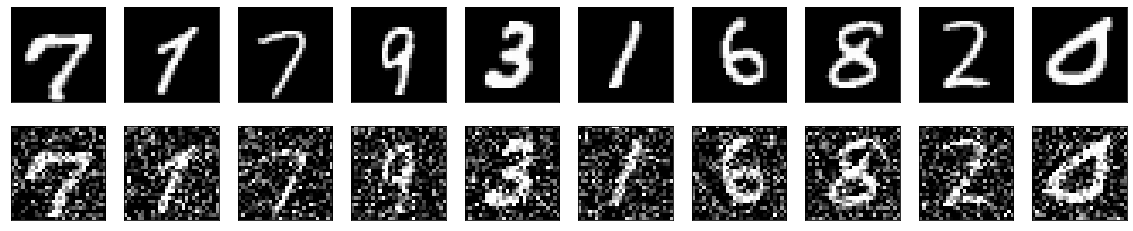

In [46]:
display(x_train, x_train_noisy)

### Autoencoder

With respect to the Conv autoencoder seen, before, we have made some modifications, like increasing the number of channels, adding a Conv layer, adding the 'relu' activation function in each Conv layer (except the last one).

In [38]:
### INPUT
xin = Input(shape=(28,28,1))

### ENCODER
x = Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')(xin)
z = Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')(x)  # Latent encoding z

### DECODER
x = Conv2DTranspose(filters=32, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')(z)
x = Conv2DTranspose(filters=32, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')(x)
xout = Conv2D(filters=1, kernel_size=(3,3), strides=1, padding='same', 
              activation='sigmoid')(x)  # Reconstructed image

### MODEL
autoencoder = Model(inputs=xin, outputs=xout)

In [39]:
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 32)        320       
                                                                 
 conv2d_10 (Conv2D)          (None, 7, 7, 32)          9248      
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 14, 14, 32)       9248      
 ranspose)                                                       
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 28, 28, 32)       9248      
 Transpose)                                                      
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 1)         289 

In [40]:
from tensorflow.keras.optimizers import Adam  # We import the optimizer
autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')

### Training

We try the autoencoder. It is important to notice that the we are giving as data $x_{train\_noisy}$, and as labels $x_{train}$. We are giving $<x_{train\_noisy},x_{train}>$ to the `fit` method.

In [41]:
autoencoder.fit(x_train_noisy, x_train, epochs=50, batch_size=128, validation_data=(x_test_noisy, x_test))

Epoch 1/50
469/469 [==============================] - 47s 100ms/step - loss: 0.1607 - val_loss: 0.0940
Epoch 2/50
469/469 [==============================] - 44s 93ms/step - loss: 0.0933 - val_loss: 0.0916
Epoch 3/50
469/469 [==============================] - 42s 90ms/step - loss: 0.0914 - val_loss: 0.0901
Epoch 4/50
469/469 [==============================] - 43s 91ms/step - loss: 0.0902 - val_loss: 0.0896
Epoch 5/50
469/469 [==============================] - 45s 97ms/step - loss: 0.0894 - val_loss: 0.0886
Epoch 6/50
469/469 [==============================] - 46s 99ms/step - loss: 0.0887 - val_loss: 0.0879
Epoch 7/50
469/469 [==============================] - 44s 95ms/step - loss: 0.0882 - val_loss: 0.0874
Epoch 8/50
469/469 [==============================] - 41s 88ms/step - loss: 0.0877 - val_loss: 0.0870
Epoch 9/50
469/469 [==============================] - 42s 91ms/step - loss: 0.0874 - val_loss: 0.0867
Epoch 10/50
469/469 [==============================] - 43s 91ms/step - loss: 0.08

### Inspect the results

Let's inspect the quality of the results.

First of all, we apply the autoencoder to the test data $x_{test\_noisy}$: we get back the denoised test images $x_{test\_denoised}$.

In [42]:
x_test_denoised = autoencoder.predict(x_test_noisy)

Now we can plot the result. 

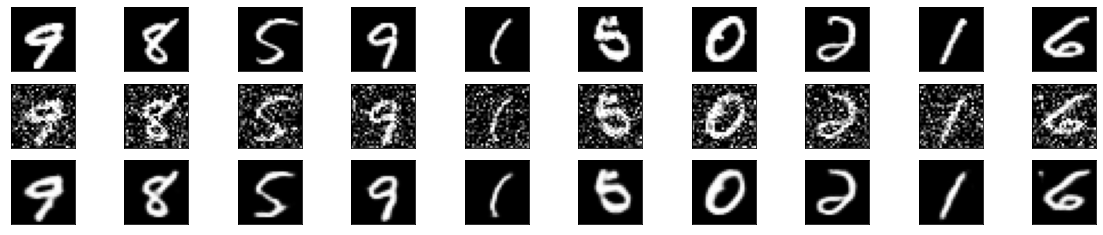

In [47]:
display(x_test, x_test_noisy, x_test_denoised)

**Very good results!**

## INSIGHT 

We have said that we can in general use Autoencoders for trying to learn every kind of transformation $f$ on our data (we must know how to perform the inverse transformation $f^{-1}$).

However, there are some kinds of transformations $f$ which are more difficult to address using this approach. More precisely, transformations $f$ which don't have only one possible output, but many possible outptuts. Non-deterministic transformations.

Example: coloring a monochrome image. Transformation $f$ of coloring a monochrome image. This is non-deterministic: many possible ways of coloring an image.

Basically, it is a multi-modal task: many possible outputs (no a single output).

In such cases, a generative approach is probably better. Generative model.